In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tqdm

Логика стратегии:

- Падает аск А упал, значит упадет и бид на Б - работаем со сделками по продаже Б
- Растет аск на А, значит вырастет бид на Б - работаем со сделками по покупке Б

Выбор сделки осуществляется оценкой разницы в цене между будущим моментом и моментом сделки

In [ ]:
data = [json.loads(x) for x in tqdm.tqdm(open('C:/Users/Aurora/Downloads/ab_801_data.txt', 'r').readlines()[:600000])]

100%|███████████████████████████████████████████████████████████████████████| 600000/600000 [00:39<00:00, 15122.07it/s]


In [ ]:
data[1]

{'human_receive_time': '2021-08-02 08:00:00.003460645',
 'human_server_time': '2021-08-02 08:00:00.002760663',
 'quotes': [[{'price': 8831.5, 'volume': 51},
   {'price': 8831.0, 'volume': 147},
   {'price': 8830.5, 'volume': 135},
   {'price': 8830, 'volume': 159},
   {'price': 8829.5, 'volume': 231},
   {'price': 8829.0, 'volume': 291},
   {'price': 8828.5, 'volume': 291},
   {'price': 8828, 'volume': 276},
   {'price': 8827.5, 'volume': 267},
   {'price': 8827.0, 'volume': 174}],
  [{'price': 8832, 'volume': 111},
   {'price': 8832.5, 'volume': 162},
   {'price': 8833.0, 'volume': 147},
   {'price': 8833.5, 'volume': 156},
   {'price': 8834, 'volume': 186},
   {'price': 8834.5, 'volume': 186},
   {'price': 8835.0, 'volume': 198},
   {'price': 8835.5, 'volume': 198},
   {'price': 8836, 'volume': 573},
   {'price': 8836.5, 'volume': 219}]],
 'receive_time': 1627891200003460645,
 'server_time': 1627891200002760663,
 'symbol': 'A',
 'type': 'OrderBook'}

In [ ]:
a_orders = [x for x in data if x['symbol'] == 'A' and x['type'] == 'OrderBook']
b_orders = [x for x in data if x['symbol'] == 'B' and x['type'] == 'OrderBook']

In [ ]:
a_best_bid_price = []
a_best_ask_price = []

for i in range(len(a_orders)):
  try:
    a_best_bid_price.append(a_orders[i]['quotes'][0][0]['price'])
    a_best_ask_price.append(a_orders[i]['quotes'][1][0]['price'])

  except IndexError:
    print(i)

b_best_bid_price = []
b_best_ask_price = []

for i in range(len(b_orders)):
  try:
    b_best_bid_price.append(b_orders[i]['quotes'][0][0]['price'])
    b_best_ask_price.append(b_orders[i]['quotes'][1][0]['price'])
  except IndexError:
    print(i)

321664


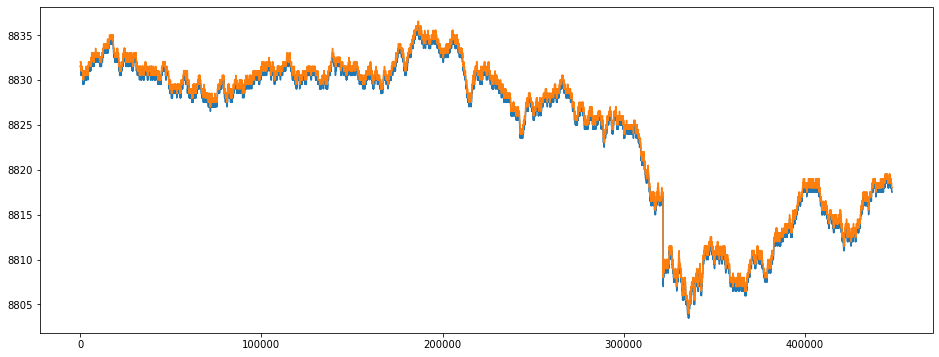

In [ ]:
fig = plt.figure(figsize=(16, 6))
plt.plot(a_best_bid_price)
plt.plot(a_best_ask_price)

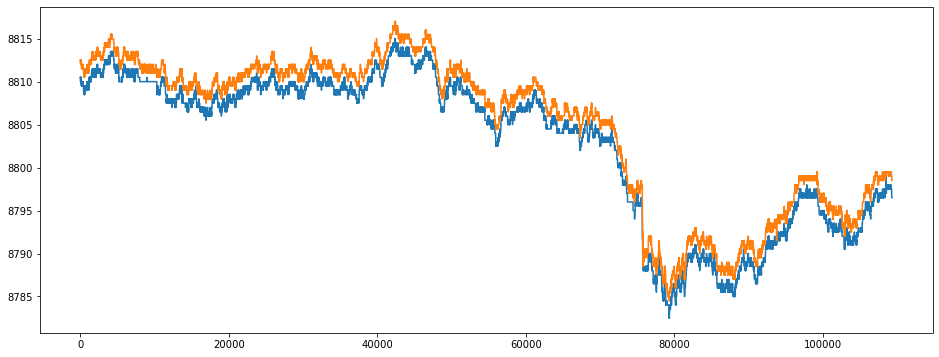

In [ ]:
fig = plt.figure(figsize=(16, 6))
plt.plot(b_best_bid_price)
plt.plot(b_best_ask_price)

In [ ]:
a_buy_deals = [x for x in data if x['symbol'] == 'A' and x['type'] == 'Deal' and x['aggressor_dir'] == 0]
b_buy_deals = [x for x in data if x['symbol'] == 'B' and x['type'] == 'Deal' and x['aggressor_dir'] == 0]
a_sell_deals = [x for x in data if x['symbol'] == 'A' and x['type'] == 'Deal' and x['aggressor_dir'] == 1]
b_sell_deals = [x for x in data if x['symbol'] == 'B' and x['type'] == 'Deal' and x['aggressor_dir'] == 1]

In [ ]:
def search_deals(all_deals, event_receive_time, deals_time_delta):
  idx = 0
  while all_deals[idx]['receive_time'] < event_receive_time and idx < len(all_deals) - 1:
    idx += 1
  if idx == len(all_deals) - 1:
    return 0, []
  left_bound = idx
  while all_deals[idx]['receive_time'] < event_receive_time + deals_time_delta and idx < len(all_deals) - 1:
    idx += 1
  if idx == len(all_deals) - 1:
    return left_bound, all_deals[left_bound:]
  right_bound = idx
  return left_bound, all_deals[left_bound : right_bound]

def search_best_deal_buy(deals, fut_price):
  profits = [(fut_price - deal['price']) * deal['volume'] for deal in deals]
  return profits.index(max(profits)), max(profits)

def search_best_deal_sell(deals, fut_price):
  profits = [(deal['price'] - fut_price) * deal['volume'] for deal in deals]
  return profits.index(max(profits)), max(profits)


delta = 1000000000

In [ ]:
import copy
b_buy_copy = copy.deepcopy(b_buy_deals)
b_sell_copy = copy.deepcopy(b_sell_deals)

In [ ]:
first_a_bid = a_best_bid_price[0]
first_a_ask = a_best_ask_price[0]
profit = [0]
used_deals = []
false_counter = 0
for a_order_index in range(len(a_orders)):
  current_ask_diff = a_orders[a_order_index]['quotes'][1][0]['price'] - first_a_ask
  if current_ask_diff == 0:
    continue
  elif current_ask_diff > 0:
    first_a_ask = a_orders[a_order_index]['quotes'][1][0]['price']
    curr_time = a_orders[a_order_index]['receive_time']
    curr_bound, current_deals = search_deals(b_buy_copy, curr_time, delta)
    if len(current_deals) == 0:
      continue

    temp_idx = 0
    while b_orders[temp_idx]['receive_time'] < curr_time + delta * 1000 and temp_idx < len(b_orders) - 1:
      temp_idx += 1
    future_price = b_orders[temp_idx]['quotes'][1][0]['price']
    best_idx, current_profit = search_best_deal_buy(current_deals, future_price)
    if current_profit < 0:
      current_profit = 0
      false_counter += 1
      continue
    profit.append(profit[len(profit) - 1] + current_profit)
    used_deals.append(current_deals[best_idx])
    b_buy_copy.pop(curr_bound + best_idx)
  else:
    first_a_ask = a_orders[a_order_index]['quotes'][1][0]['price']
    curr_time = a_orders[a_order_index]['receive_time']
    curr_bound, current_deals = search_deals(b_sell_copy, curr_time, delta)
    if len(current_deals) == 0:
      continue

    temp_idx = 0
    while b_orders[temp_idx]['receive_time'] < curr_time + delta * 1000 and temp_idx < len(b_orders) - 1:
      temp_idx += 1
    future_price = b_orders[temp_idx]['quotes'][0][0]['price']
    best_idx, current_profit = search_best_deal_sell(current_deals, future_price)
    if current_profit < 0:
      current_profit = 0
      false_counter += 1
      continue
    profit.append(profit[len(profit) - 1] + current_profit)
    used_deals.append(current_deals[best_idx])
    b_sell_copy.pop(curr_bound + best_idx)

In [ ]:
profit

[0,
 6,
 6.0,
 15.0,
 33.0,
 45.0,
 57.0,
 84.0,
 103.5,
 118.5,
 166.5,
 169.5,
 187.5,
 205.5,
 223.5,
 231.0,
 231.0]